<a href="https://colab.research.google.com/github/FatimaBatool820/Assignment_02_PAI/blob/main/Assignment_02_Reduced_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score,auc

# **Data Understanding**

In [ ]:
heart=pd.read_csv('framingham.csv')
heart.isnull().sum()

,0
male,0
age,0
education,105
currentSmoker,0
cigsPerDay,29
BPMeds,53
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,50


In [ ]:
heart.columns

Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [ ]:
heart.dtypes

,0
male,int64
age,int64
education,float64
currentSmoker,int64
cigsPerDay,float64
BPMeds,float64
prevalentStroke,int64
prevalentHyp,int64
diabetes,int64
totChol,float64


# **Data Imputation**

In [ ]:
# Fill missing values with the median for numerical columns
for col in ['cigsPerDay', 'totChol', 'BMI', 'heartRate', 'glucose']:
  heart[col] = heart[col].fillna(heart[col].median())

# Fill missing values with the mode for categorical columns
for col in ['education', 'BPMeds']:
  heart[col] = heart[col].fillna(heart[col].mode()[0])

# **Data Balancing**

In [ ]:
heart['TenYearCHD'].value_counts()

,count
TenYearCHD,
0,3596
1,644


# **Reduce Features**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
#select top k feature relevant to Target (feature selection method), based on scoring function give ranks
#f_classif is a scoring function

In [ ]:
# Target
y = heart['TenYearCHD']

# Select only numerical features for ANOVA-F (it's works only with numerical features)
X = heart[[
    'male', 'age', 'education', 'currentSmoker', 'cigsPerDay',
    'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes',
    'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'
]]

<ipython-input-37-8886f4263ed1>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F-score', y='Feature', data=anova_results, palette='viridis')


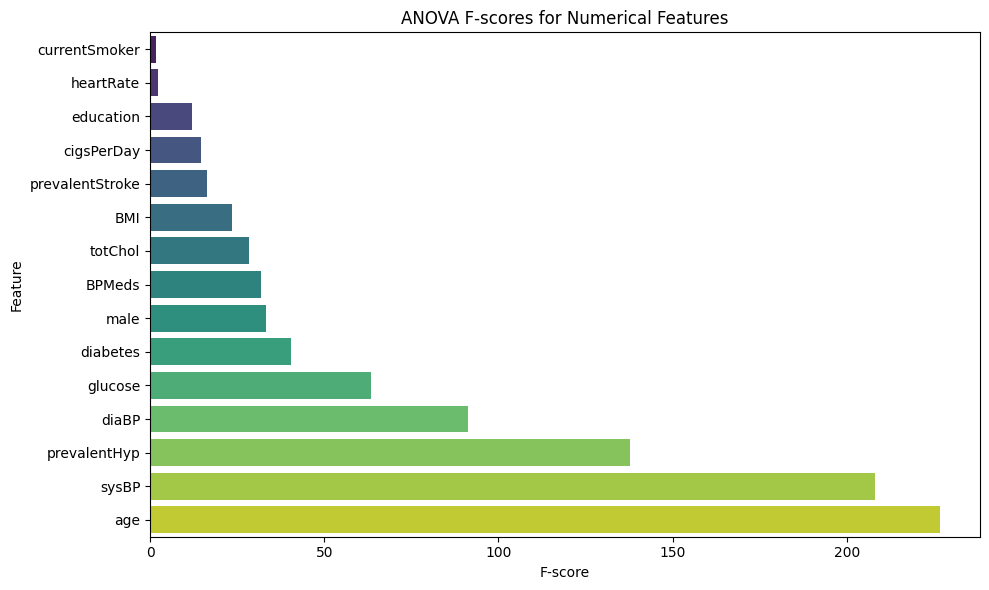

In [ ]:
# Apply SelectKBest with ANOVA F-test
selector = SelectKBest(score_func=f_classif, k='all')
X_selected = selector.fit_transform(X, y)

# Extract scores and p-values
#gives you the F-scores for each feature.
scores = selector.scores_
pvalues = selector.pvalues_
#p-value tells confidently that a feature is genuinely related to target

# Combine into a DataFrame
anova_results = pd.DataFrame({
    'Feature': X.columns,
    'F-score': scores,
    'p-value': pvalues
}).sort_values(by='F-score', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='F-score', y='Feature', data=anova_results, palette='viridis')
plt.title('ANOVA F-scores for Numerical Features')
plt.xlabel('F-score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [ ]:
heart = heart.drop(['male', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds','prevalentStroke', 'diabetes', 'totChol', 'BMI', 'heartRate', 'glucose'], axis=1)

In [ ]:
heart.columns

Index(['age', 'prevalentHyp', 'sysBP', 'diaBP', 'TenYearCHD'], dtype='object')

# **Random Forest Implementation**

In [ ]:
X = heart.drop('TenYearCHD', axis=1) #All feature except 'Target'
y = heart['TenYearCHD'] #Target Column

# 1. Split your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 3. Define the Random Forest pipeline (with scaling)
clf=RandomForestClassifier(n_estimators=100, random_state=17)

# 4. Fit the pipeline on resampled training data
clf.fit(X_train_resampled, y_train_resampled)

# 5. Predict and evaluate on the original test data
y_pred = clf.predict(X_test)

accuracy_RF = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy_RF:.2f}")

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Support: Number of true instances for each class.
print("Classification Report:\n",classification_report(y_test, y_pred))


Model Accuracy: 0.75
Balanced Accuracy: 0.53
F1 Score: 0.21
Confusion Matrix:
[[603 116]
 [100  29]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85       719
           1       0.20      0.22      0.21       129

    accuracy                           0.75       848
   macro avg       0.53      0.53      0.53       848
weighted avg       0.76      0.75      0.75       848



In [ ]:
# 1. Get predicted probabilities from the classifier (only positive class)
y_proba = clf.predict_proba(X_test)[:, 1]

# 2. Compute AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.59


# **Experimental Tracking_RF**

In [ ]:
import mlflow
import mlflow.sklearn

# Set MLflow tracking and experiment
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Random_Forest Experiment")

with mlflow.start_run():

    # 1. Log ANOVA F-test results
    mlflow.log_param("feature_selection", "ANOVA F-test")

    # Log top 5 ANOVA F-scores and p-values
    top_n = 5
    for i in range(top_n):
        feature_name = anova_results.iloc[-(i+1)]['Feature']
        f_score = anova_results.iloc[-(i+1)]['F-score']
        p_value = anova_results.iloc[-(i+1)]['p-value']
        mlflow.log_metric(f"F_score_{feature_name}", f_score)
        mlflow.log_metric(f"p_value_{feature_name}", p_value)

    # Log full ANOVA table as artifact
    anova_results.to_csv("anova_results.csv", index=False)
    mlflow.log_artifact("anova_results.csv")

    # 2. Log model parameters
    mlflow.log_param("model", "Random Forest")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 10)
    mlflow.log_param("random_state", 42)

    # 3. Train model
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(X_train, y_train)

    # 4. Log evaluation metrics
    mlflow.log_metric("accuracy", accuracy_RF)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    mlflow.log_metric("balanced_accuracy", balanced_accuracy)
    f1 = f1_score(y_test, y_pred)
    mlflow.log_metric("f1_score", f1)

    # 5. Log trained model
    mlflow.sklearn.log_model(rf_model, "Random_Forest_Model")

    print("Random Forest model, ANOVA results, and metrics logged in MLflow")

# **KNN Implementation**

In [ ]:
X = heart.drop(['TenYearCHD'], axis=1)
y = heart['TenYearCHD']

#Split Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Apply KNN+BBC
knn = KNeighborsClassifier(n_neighbors=5)
bbc = BalancedBaggingClassifier(knn,sampling_strategy='auto',replacement=False, random_state=42,n_estimators=10)
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)
#Accuracy
accuracy_KNN = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy_KNN:.2f}")

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Support: Number of true instances for each class.
print("Classification Report:\n",classification_report(y_test, y_pred))


Model Accuracy: 0.62
Balanced Accuracy: 0.61
F1 Score: 0.31
Confusion Matrix:
[[457 268]
 [ 50  73]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.63      0.74       725
           1       0.21      0.59      0.31       123

    accuracy                           0.62       848
   macro avg       0.56      0.61      0.53       848
weighted avg       0.80      0.62      0.68       848



In [ ]:
# 1. Get predicted probabilities from the classifier (only positive class)
y_proba = bbc.predict_proba(X_test)[:, 1]

# 2. Compute AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.67


# **Expeimental Tracking_KNN**

In [ ]:
import mlflow
import mlflow.sklearn

# Set MLflow tracking URI and experiment
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("KNearest_Neighbour Experiment")

# Start MLflow run
with mlflow.start_run() as run:
    # Train your model
    knn = KNeighborsClassifier(n_neighbors=5)
    bbc = BalancedBaggingClassifier(estimator=knn, sampling_strategy='auto', replacement=False, random_state=42, n_estimators=10)
    bbc.fit(X_train, y_train)
    y_pred = bbc.predict(X_test)

    # Evaluate model
    accuracy_KNN = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model Accuracy: {accuracy_KNN:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

    # Log model parameters
    mlflow.log_param("model", "KNN + Balanced Bagging Classifier")
    mlflow.log_param("n_neighbors", 5)
    mlflow.log_param("n_estimators", 10)
    mlflow.log_param("sampling_strategy", 'auto')

    # Log evaluation metrics
    mlflow.log_metric("accuracy", accuracy_KNN)
    mlflow.log_metric("balanced_accuracy", balanced_accuracy)
    mlflow.log_metric("f1_score", f1)

    # Log ANOVA F-test info
    mlflow.log_param("feature_selection", "ANOVA F-test")

    # Log top 5 ANOVA scores
    top_n = 5
    for i in range(top_n):
        feature_name = anova_results.iloc[-(i + 1)]['Feature']
        f_score = anova_results.iloc[-(i + 1)]['F-score']
        p_value = anova_results.iloc[-(i + 1)]['p-value']
        mlflow.log_metric(f"F_score_{feature_name}", f_score)
        mlflow.log_metric(f"p_value_{feature_name}", p_value)

    # Save full ANOVA results as a CSV and log as artifact
    anova_results.to_csv("anova_results_knn.csv", index=False)
    mlflow.log_artifact("anova_results_knn.csv")

    print("Model, metrics, and ANOVA F-test results logged in MLflow.")

# **Decision Tree Implementation**

In [ ]:
X = heart.drop(['TenYearCHD'], axis=1)
y = heart['TenYearCHD']

#Split Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Apply DT+BBC
DT = DecisionTreeClassifier(random_state=42)
bbc = BalancedBaggingClassifier(DT,sampling_strategy='auto',replacement=False, random_state=42,n_estimators=10)
bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)

#Accuracy
accuracy_DT = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy_DT:.2f}")

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.2f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Support: Number of true instances for each class.
print("Classification Report:\n",classification_report(y_test, y_pred))


Model Accuracy: 0.72
Balanced Accuracy: 0.58
F1 Score: 0.28
Confusion Matrix:
[[569 156]
 [ 78  45]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83       725
           1       0.22      0.37      0.28       123

    accuracy                           0.72       848
   macro avg       0.55      0.58      0.55       848
weighted avg       0.78      0.72      0.75       848



In [ ]:
# 1. Get predicted probabilities from the classifier (only positive class)
y_proba = bbc.predict_proba(X_test)[:, 1]

# 2. Compute AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.62


# **Expeimental Tracking_DT**

In [ ]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Decision_Tree Experiment")

with mlflow.start_run():
    # Train model
    bbc.fit(X_train, y_train)
    y_pred = bbc.predict(X_test)

    # Accuracy
    accuracy_DT = accuracy_score(y_test, y_pred)
    print(f"\nModel Accuracy: {accuracy_DT:.2f}")
    mlflow.log_metric("accuracy", accuracy_DT)

    # Balanced accuracy
    score = balanced_accuracy_score(y_test, y_pred)
    print("Balanced Accuracy:", score)
    mlflow.log_metric("balanced_accuracy", score)

    # F1-score
    f1 = f1_score(y_test, y_pred)
    print(f"F1-Score: {f1:.2f}")
    mlflow.log_metric("f1_score", f1)

    # Log model parameters
    mlflow.log_param("model", "Decision Tree + Balanced Bagging Classifier")
    mlflow.log_param("n_estimators", 10)
    mlflow.log_param("sampling_strategy", "auto")
    mlflow.log_param("random_state", 42)

    # Log confusion matrix as artifact
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    cm_fig_path = "confusion_matrix.png"
    plt.savefig(cm_fig_path)
    mlflow.log_artifact(cm_fig_path)

    # Log classification report to text
    report = classification_report(y_test, y_pred)
    with open("classification_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report.txt")

    # Log ANOVA F-test results
    mlflow.log_param("feature_selection", "ANOVA F-test")

    # Log top N features from ANOVA
    top_n = 5
    for i in range(top_n):
        feature = anova_results.iloc[-(i + 1)]
        mlflow.log_metric(f"F_score_{feature['Feature']}", feature['F-score'])
        mlflow.log_metric(f"p_value_{feature['Feature']}", feature['p-value'])

    # Save and log full ANOVA results
    anova_results.to_csv("anova_results_dt.csv", index=False)
    mlflow.log_artifact("anova_results_dt.csv")

    # Log model
    mlflow.sklearn.log_model(bbc, "Balanced_Bagging_Model")

    print("DT + BBC model, metrics, and ANOVA results logged in MLflow.")

# **Comparsion of Models**

<ipython-input-44-cdd8b2ce176e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=data, palette='Set2')


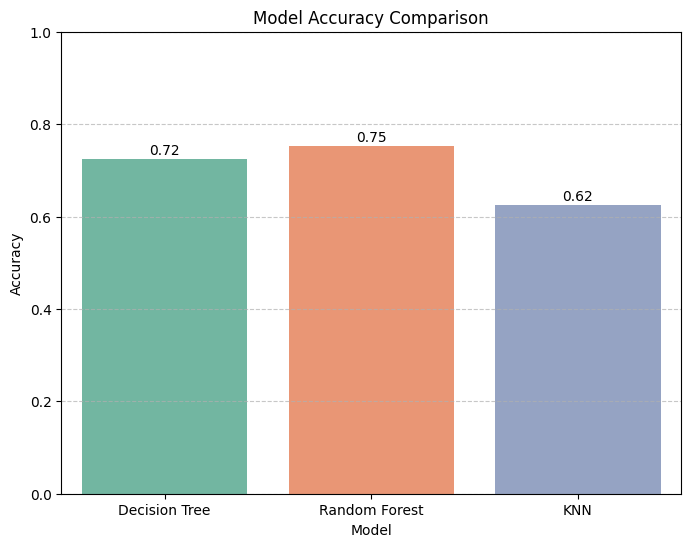

In [ ]:
# Create a DataFrame
data = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'KNN'],
    'Accuracy': [accuracy_DT, accuracy_RF, accuracy_KNN]
})

# Barplot
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=data, palette='Set2')

# Annotate
for index, row in data.iterrows():
    plt.text(index, row.Accuracy + 0.01, f'{row.Accuracy:.2f}', ha='center')

plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **MlFlow Comparsion Chart**

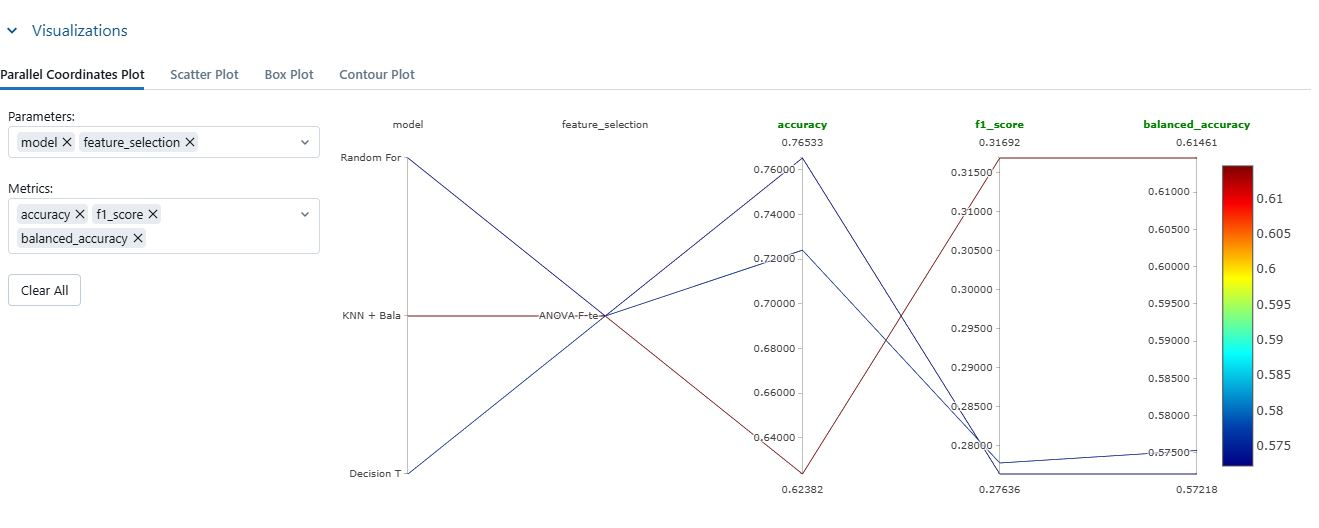

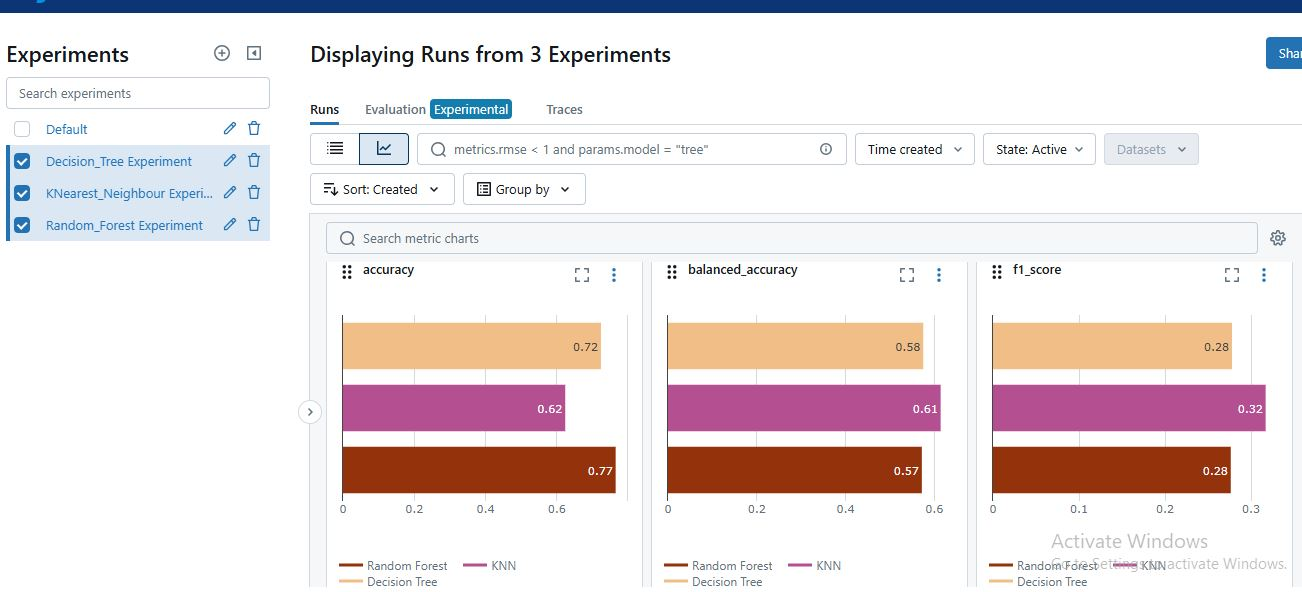

# **Reasoning:**
Models demonstrate significantly higher accuracy with Random Forest Tree and Decision, the F1-scores and balanced accuracy are relatively lower. Due to the nature of the imbalanced dataset, where accuracy alone can be misleading. Unlike the paper's approach, which involved dropping rows with missing values and using random sampling, I employed a more robust data preprocessing pipeline imputing missing values (median/mode). The use of SMOTE and ensemble techniques like Balanced Bagging introduced synthetic samples, which led the models to be more cautious in predicting the minority class, hence slightly lower F1-scores and balanced accuracy. This trade-off reflects a clinically important bias toward reducing false positives, which is often preferable in healthcare settings.
For Reduced ANOVA-F Test technqique is based on models applied above the columns which impact highly on Target column is different as compared to mention in paper.But, overall accuracy improved.

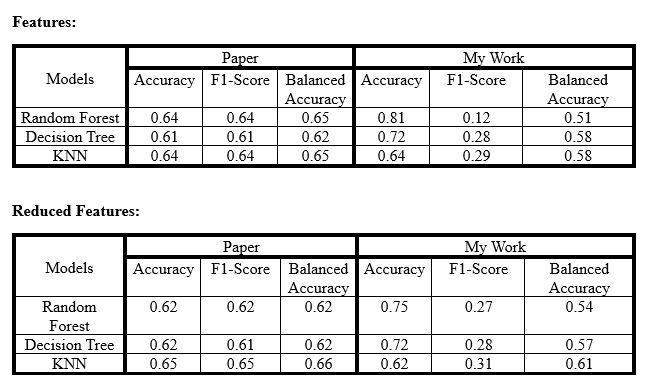